d:\Programs\miniconda3\envs\qiskit\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\Programs\miniconda3\envs\qiskit\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Programs\miniconda3\envs\qiskit\Lib\site-packages\matplotlib\transforms.py:2855: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


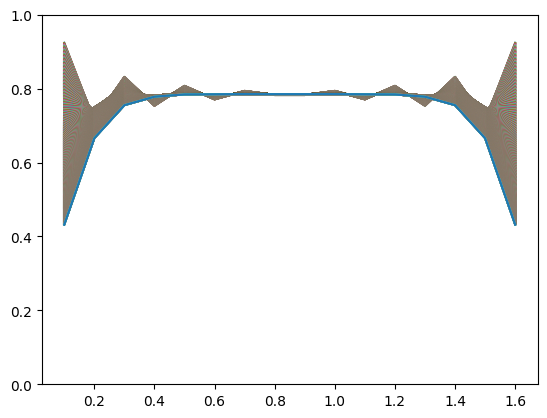

In [1]:
from qnute.hamiltonian.laplacian import generateLaplaceHamiltonian1D, generateGrayCodeLaplacian1D
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from tests.heat_eqn import run_1D_heat_eqn_simulation
n = 4
Nx = 2**n
dx = 0.1
T = 1.0
dtau = 0.1
alpha = 0.01
D_list = [2,4]

L = (Nx+1)*dx
x = np.arange(1,Nx+1)*dx

psi0 = np.zeros(Nx,dtype=np.float64)
for i in range(1,Nx+1,2):
    psi0 += (1.0/i) * np.sin(i*np.pi*x/L)

qite_sols = run_1D_heat_eqn_simulation(n, dx, T, dtau, alpha, psi0.copy(), False, D_list)
dt = dtau*dx*dx
Nt = np.int32(np.ceil(T/dt))
times = np.arange(Nt+1)*dt
# plt.plot(x,qite_sols[0,0,:])

for ti,t in enumerate(times):
    plt.plot(x, qite_sols[1,ti,:])
plt.ylim([np.min([0.0, np.min(qite_sols[1,:,:])]),np.max([1.0, np.max(qite_sols[1,:,:])])])
plt.show()

In [2]:
psi0

array([0.92415515, 0.71272754, 0.83183913, 0.75359428, 0.80737867,
       0.77087489, 0.79370576, 0.78269128, 0.78269128, 0.79370576,
       0.77087489, 0.80737867, 0.75359428, 0.83183913, 0.71272754,
       0.92415515])

In [3]:
from tests.heat_eqn import get_zero_bc_frequency_amplitudes, get_zero_bc_analytical_solution
frequency_amplitudes = get_zero_bc_frequency_amplitudes(psi0.copy(), dx, L)
analytical_solution = get_zero_bc_analytical_solution(frequency_amplitudes, L, Nx, dx, Nt, dt, alpha)

fidelities = np.zeros((len(D_list), Nt+1), dtype=np.float64)
log_norm_ratios = np.zeros(fidelities.shape, dtype=np.float64)
mean_sq_err = np.zeros(fidelities.shape, dtype=np.float64)


for Di,D in enumerate(D_list):
    for ti,t in enumerate(times):
        fidelities[Di,ti] = np.abs(np.vdot(qite_sols[Di,ti,:], analytical_solution[ti,:])) / (np.linalg.norm(analytical_solution[ti,:]) * np.linalg.norm(qite_sols[Di,ti,:]))
        log_norm_ratios[Di,ti] = np.log(np.linalg.norm(analytical_solution[ti,:])) - np.log(np.linalg.norm(qite_sols[Di,ti,:]))
        mean_sq_err[Di,ti] = np.mean((analytical_solution[ti,:] - qite_sols[Di,ti,:])**2)

psi0

C:\Users\swaga\AppData\Local\Temp\ipykernel_3804\3402515176.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  mean_sq_err[Di,ti] = np.mean((analytical_solution[ti,:] - qite_sols[Di,ti,:])**2)


array([0.92415515, 0.71272754, 0.83183913, 0.75359428, 0.80737867,
       0.77087489, 0.79370576, 0.78269128, 0.78269128, 0.79370576,
       0.77087489, 0.80737867, 0.75359428, 0.83183913, 0.71272754,
       0.92415515])

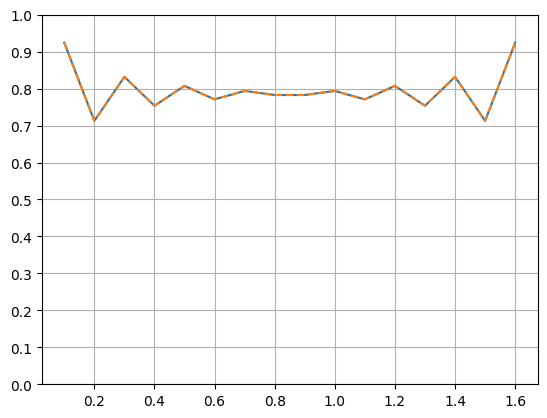

In [12]:
# plt.plot(np.arange(Nx),frequency_amplitudes)
f = np.zeros(Nx)
for i in range(Nx):
    f += frequency_amplitudes[i]*np.sin((i+1)*np.pi*x/L)
plt.plot(x,f)
plt.plot(x,psi0,linestyle='--')
plt.grid(True)
plt.yticks(np.arange(0.0,1.01,0.1))
plt.show()

In [11]:
f-psi0

array([ 1.22124533e-15, -1.44328993e-15,  1.66533454e-15, -8.88178420e-16,
        0.00000000e+00, -4.44089210e-16,  1.22124533e-15,  7.77156117e-16,
        2.22044605e-16, -5.55111512e-16,  3.33066907e-16, -4.44089210e-16,
       -2.22044605e-16,  1.55431223e-15,  6.66133815e-16, -1.33226763e-15])

In [10]:
np.linalg.norm(f)

2.9154759474226504

C:\Users\swaga\AppData\Local\Temp\ipykernel_3804\2280975280.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  f[1:-1] = qite_sols[row,ti,:]


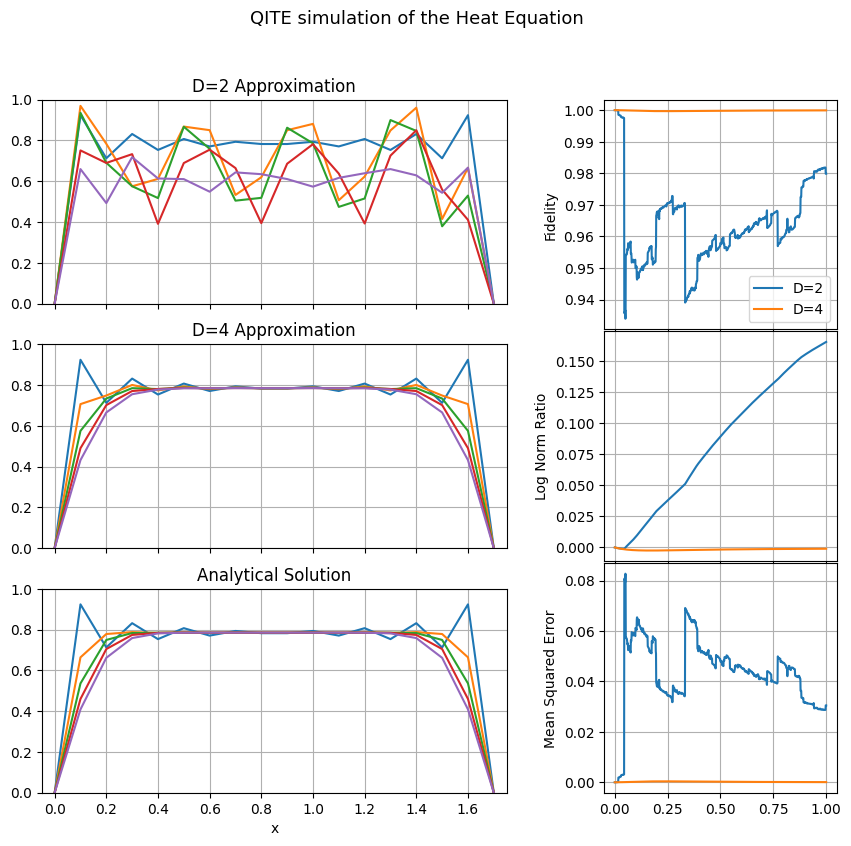

In [30]:
plot_times = np.array([0, Nt//4, Nt//2, 3*Nt//4, Nt])
stats = np.array([fidelities, log_norm_ratios, mean_sq_err])

figure = plt.figure(figsize=(9,9))
figure.set_facecolor('white')
figure.suptitle('QITE simulation of the Heat Equation', fontsize=13)
evo_fig, stats_fig = figure.subfigures(1,2,width_ratios=(2,1))
evo_axs = evo_fig.subplots(len(D_list)+1,1, sharex=True, sharey=True)
stats_axs = stats_fig.subplots(3,1, sharex=True)

plot_x = np.arange(0,Nx+2)*dx
f = np.zeros(Nx+2)

dense_x = np.arange(0.0,L,0.01)

from numba import njit

@njit
def get_interpolation(psi, dense_x, L):
    frequency_amplitudes = get_zero_bc_frequency_amplitudes(psi.copy(), dense_x[1]-dense_x[0], L)
    f_interpolate = np.zeros(dense_x.shape[0],dtype=np.float64)


for row,ax in enumerate(evo_axs):
    if row < len(D_list):
        ax.set_title(f'D={D_list[row]} Approximation')
        for ti in plot_times:
            f[1:-1] = qite_sols[row,ti,:]
            ax.plot(plot_x,f)
        ax.grid(True)
    else:
        ax.set_title('Analytical Solution')
        for ti in plot_times:
            f[1:-1] = analytical_solution[ti,:]
            ax.plot(plot_x,f)
        ax.grid(True)
        ax.set_ylim([0.0,1.0])
        ax.set_xlim([-dx/2,L+dx/2])
        ax.set_xticks(np.arange(0.0,L+dx,2*dx))
        ax.set_xlabel('x')

stat_titles = ['Fidelity',
               'Log Norm Ratio',
               'Mean Squared Error']

for row,ax in enumerate(stats_axs):
    for Di,D in enumerate(D_list):
        ax.plot(times, stats[row,Di,:], label=f'D={D}')
    if row == 0:
        ax.legend()
    ax.set_ylabel(stat_titles[row])
    ax.grid(True)


evo_fig.subplots_adjust(hspace=0.2)
stats_fig.subplots_adjust(hspace=0.01)

plt.show()

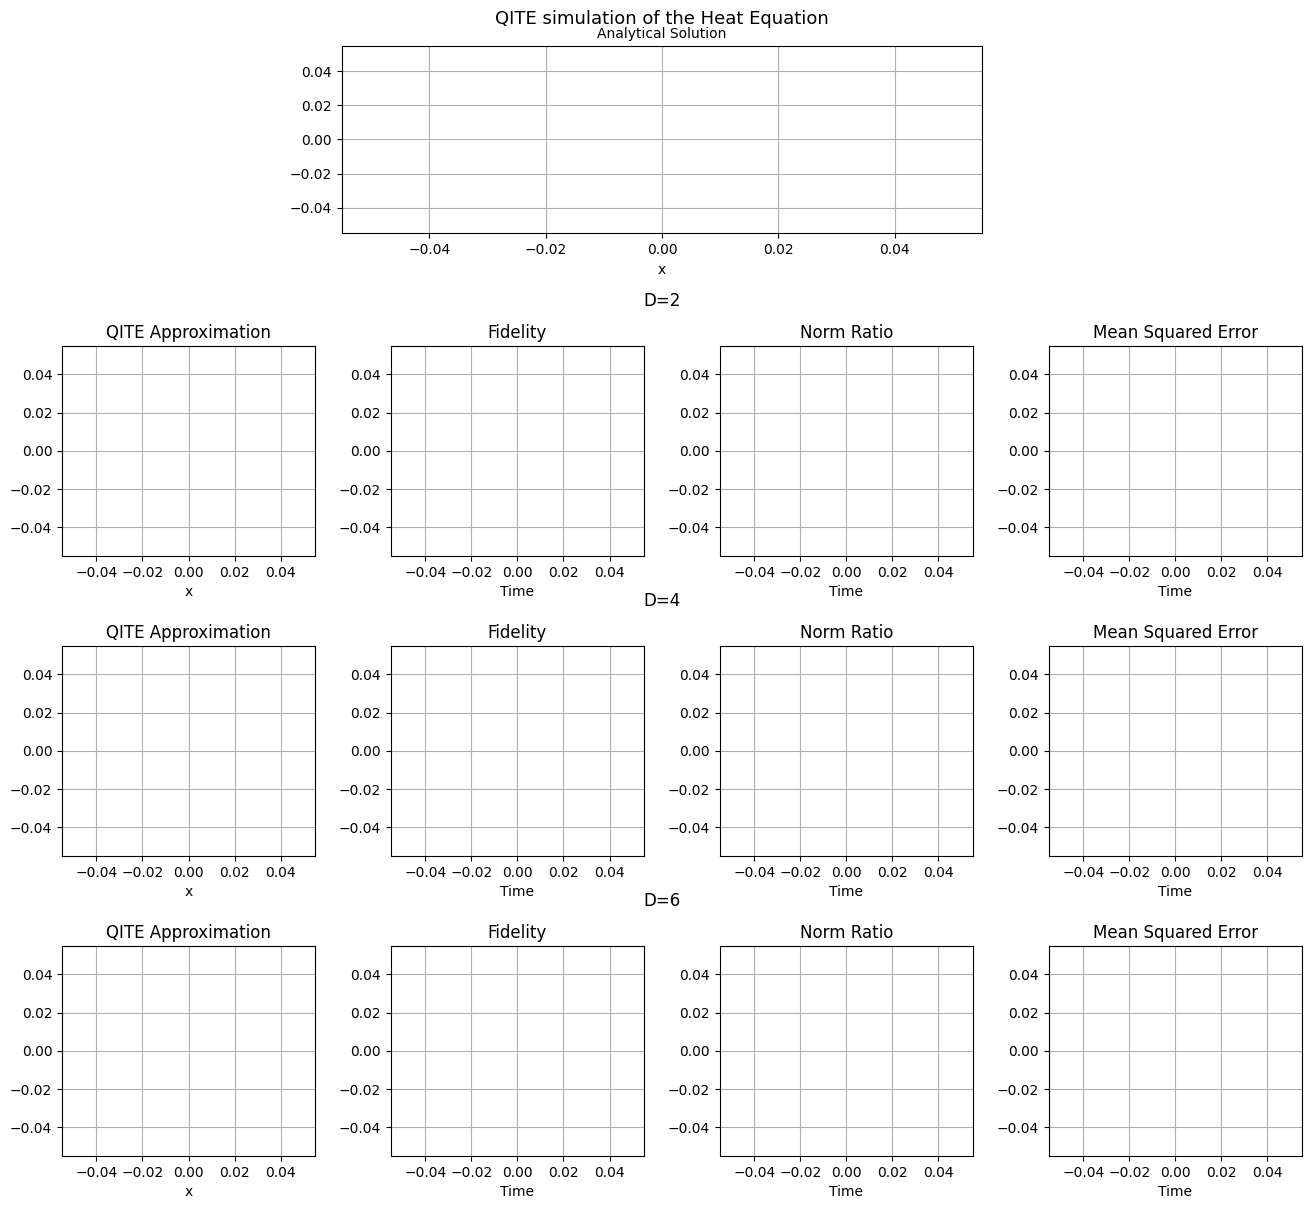

In [2]:
figure = plt.figure(figsize=(16,12))
figure.set_facecolor('white')
figure.suptitle('QITE simulation of the Heat Equation',fontsize=13)
f1,f2 = figure.subfigures(2,1,height_ratios=(1,3))
# f1.set_facecolor('green')
# f2.set_facecolor('blue')
ax1 = f1.subplots()
ax1.set_title('Analytical Solution',fontsize=10)
ax1.plot()
ax1.set_xlabel('x')
ax1.grid(True)

col_titles = ['QITE Approximation', 'Fidelity', 'Norm Ratio', 'Mean Squared Error']
d_subfigs = f2.subfigures(3,1)
for row,subfig in enumerate(d_subfigs):
    subfig.suptitle(f'D={2*(row+1)}',fontsize=12)
    axs = subfig.subplots(1,4)
    for col, ax in enumerate(axs):
        ax.plot()
        ax.set_title(col_titles[col])
        if col == 0:
            ax.set_xlabel('x')
        else:
            ax.set_xlabel('Time')
        ax.grid(True)
    subfig.subplots_adjust(wspace=0.3,hspace=0.5, bottom=0.1, top=0.8)
f1.subplots_adjust(left=0.3, right=0.7, top=0.8, bottom=0.175)

plt.show()


d:\Programs\miniconda3\envs\qiskit\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\Programs\miniconda3\envs\qiskit\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


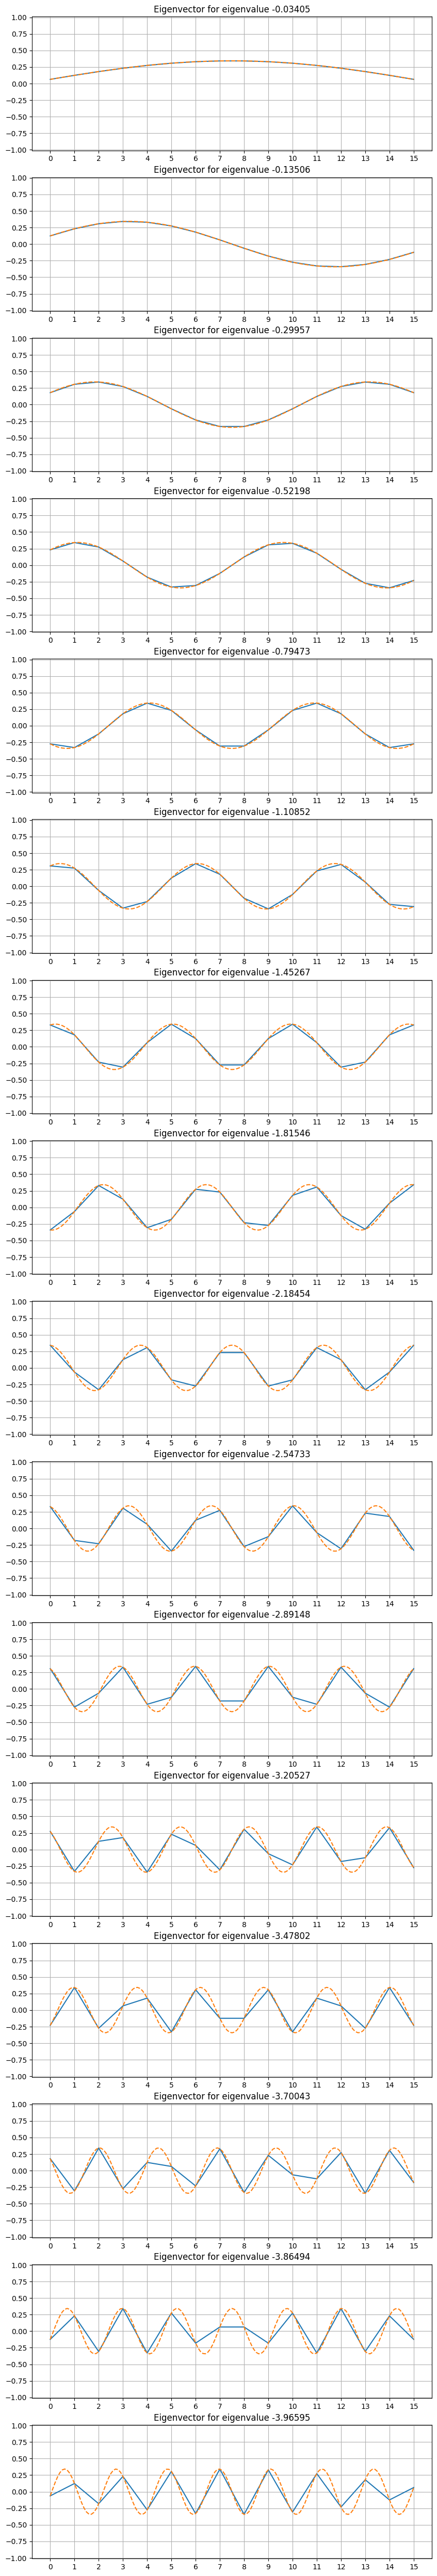

In [54]:
num_qbits = 4
Nx = 2**num_qbits
periodic_bc_flag=True
H = generateLaplaceHamiltonian1D(num_qbits,periodic_bc_flag=periodic_bc_flag)

L = Nx + 1
dx = 0.1
eig_vals, eig_states = H.get_spectrum()
idx = eig_vals.argsort()[::-1]   
eig_vals = eig_vals[idx]
eig_states = eig_states[:,idx]
fig,ax = plt.subplots(2**num_qbits,1, figsize=(10, (2**num_qbits)*4))
for i,val in enumerate(eig_vals.real):
    state = eig_states[:,i]
    state /= np.linalg.norm(state)
    if not periodic_bc_flag:
        x = np.arange(0.0,Nx-1 + dx,dx)
        sine = np.sin(np.pi*(x+1.0)*(i+1)/L)
        sine *= state[0].real/sine[0]
    else:
        x = np.arange(0.0,Nx+dx,dx)
        if i %2 == 0:
            sine = np.cos(np.pi*(x)*(i)/(L-1))
        else:
            sine = np.sin(np.pi*(x)*(i+1)/(L-1))
        sine *= state[1].real/sine[int(np.ceil(1.0/dx))]
    # sine/= np.linalg.norm
    ax[i].plot(np.arange(2**num_qbits), state, label='Eigenstate')
    ax[i].plot(x, sine, label=f'Sine of frequency {i+1}',linestyle='--')
    # print(f"Eigen value: {val}, State: {eig_states[:,i]}")
    ax[i].grid(True)
    ax[i].set_ylim([-1.01,1.01])
    ax[i].set_xticks(np.arange(2**num_qbits))
    ax[i].set_title(f'Eigenvector for eigenvalue {val:0.5f}')
plt.show()

In [52]:
H.get_gs()

((-3.9659461993678025+0j),
 array([-0.06302556-0.j,  0.12390487-0.j, -0.18056474-0.j,  0.2310757 -0.j,
        -0.27371765-0.j,  0.30703848-0.j, -0.32990347-0.j,  0.341534  +0.j,
        -0.341534  -0.j,  0.32990347-0.j, -0.30703848-0.j,  0.27371765-0.j,
        -0.2310757 -0.j,  0.18056474-0.j, -0.12390487-0.j,  0.06302556-0.j]))

d:\Programs\miniconda3\envs\qiskit\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\Programs\miniconda3\envs\qiskit\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


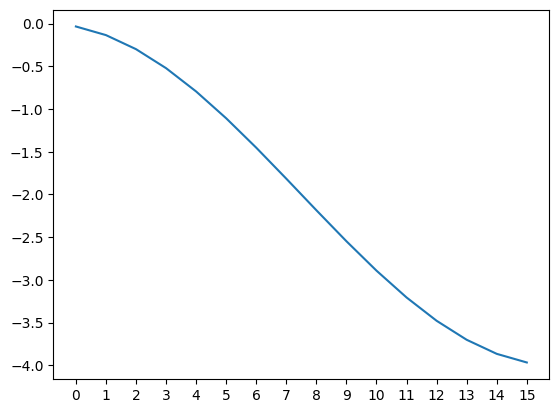

In [32]:
plt.plot(np.arange(2**num_qbits), eig_vals)
plt.xticks(np.arange(2**num_qbits))
plt.show()

In [3]:
from itertools import combinations
from qnute.hamiltonian import Hamiltonian
from qnute.helpers.lattice import get_center, manhattan_dist
import numpy as np
from math import isclose

# S:set[int] = {3}
# u_domains:list[set[int]] = [
#     {0,1}, {1,2}, {2,3}, {3,4}
# ]
# invert_map = {i:(i,0) for i in range(5)}
# S_center = get_center([invert_map[index] for index in S])
# u_domain_centers:list[np.ndarray[float]] = [get_center([invert_map[index] for index in domain]) for domain in u_domains]

# print('Support:',S)
# r = 1
# if len(S) > len(u_domains[0]):
#     r+=1
# found_flag = False
# min_dist = float('inf')
# u_index_list = []
# while r < len(u_domains) and not found_flag:
#     print(f'r={r}')
#     for u_indices in combinations(range(len(u_domains)), r):
#         u = [u_domains[i] for i in u_indices]
#         print('\nCombination:', u)
#         x = set.union(*u)
#         print('    Union:  ', x)
#         if S.issubset(x):
#             found_flag = True
#             print('    Support is a subset of the union!')
#             dist = 0.0
#             for i in u_indices:
#                 dist += manhattan_dist(S_center, u_domain_centers[i])
#             print(f'        Distance of cover from support center:    {dist}')
#             if isclose(dist,min_dist):
#                 u_index_list += list(u_indices)
#             else:
#                 if dist < min_dist:
#                     min_dist = dist
#                     u_index_list = list(u_indices)
            
#     print()
#     r += 1
# if not found_flag:
#     u_index_list = list(range(len(u_domains)))
# else:
#     r -= 1
# print(f'Number of covering domains: {r}')
# print(f'Minimum Distance: {min_dist}')
# print(f'U indices:        {u_index_list}')

In [4]:
def get_minimum_cover(support:set[int], u_domains:list[set[int]], invert_map:dict[int,tuple[int]]) -> list[int]:
    support_center = get_center([invert_map[index] for index in support])
    u_domain_centers:list[np.ndarray[float]] = [get_center([invert_map[index] for index in domain]) for domain in u_domains]

    r = 1
    if len(support) > len(u_domains[0]):
        r+=1
    found_flag = False
    min_dist = float('inf')
    u_index_list = []
    while r < len(u_domains) and not found_flag:
        for u_indices in combinations(range(len(u_domains)), r):
            u = [u_domains[i] for i in u_indices]
            x = set.union(*u)
            if support.issubset(x):
                found_flag = True
                dist = 0.0
                for i in u_indices:
                    dist += manhattan_dist(support_center, u_domain_centers[i])
                if isclose(dist,min_dist):
                    u_index_list += list(u_indices)
                else:
                    if dist < min_dist:
                        min_dist = dist
                        u_index_list = list(u_indices)
                
        # print()
        r += 1
    if not found_flag:
        u_index_list = list(range(len(u_domains)))
    else:
        r -= 1
    return u_index_list

In [5]:
def get_support(ham:Hamiltonian, term:int) -> set[int]:
    p = ham.pterm_list[ham.hm_indices[term]]['pauli_id']
    support = set()
    for i in range(ham.nbits):
        if p % 4 != 0:
            support.add(i)
        p //= 4
    return support

# get_support(ham, 2)

In [27]:
# from qnute.hamiltonian import Hamiltonian
from qnute.hamiltonian.laplacian import generateLaplaceHamiltonian1D

num_qbits = 3
ham:Hamiltonian = generateLaplaceHamiltonian1D(num_qbits)
print(ham)
u_domains = [{i,i+1} for i in range(num_qbits-1)]
invert_map = {i:(i,) for i in range(num_qbits)}

def get_amplitude_splits(ham:Hamiltonian, u_domains:list[set[int]], invert_map:dict[int,tuple[int]]):
    amplitude_splits = np.zeros((ham.num_terms,len(u_domains)),dtype=np.float64)

    for term in range(ham.num_terms):
        support = get_support(ham, term)
        
        u_index_list = get_minimum_cover(support, u_domains, invert_map)
        frac = 1.0/len(u_index_list)
        for ui in u_index_list:
            amplitude_splits[term,ui] += frac
    return amplitude_splits

amplitude_splits = get_amplitude_splits(ham, u_domains, invert_map)
print(amplitude_splits)

Hamiltonian Pauli Terms and Amplitudes:

	I_2 I_1 X_0  : (1.00000+0.00000j)

	I_2 X_1 X_0  : (0.50000+0.00000j)
	I_2 Y_1 Y_0  : (0.50000+0.00000j)

	X_2 X_1 X_0  : (0.25000+0.00000j)
	X_2 Y_1 Y_0  : (-0.25000+0.00000j)
	Y_2 X_1 Y_0  : (0.25000+0.00000j)
	Y_2 Y_1 X_0  : (0.25000+0.00000j)
	I_2 I_1 I_0  : (-2.00000+0.00000j)

[[1.  0. ]
 [1.  0. ]
 [0.5 0.5]]


In [28]:
ham.hm_list

[[array([1], dtype=uint32), array([1.+0.j]), array([0], dtype=uint32)],
 [array([ 5, 10], dtype=uint32),
  array([0.5+0.j, 0.5+0.j]),
  array([0, 1], dtype=uint32)],
 [array([21, 26, 38, 41,  0], dtype=uint32),
  array([ 0.25+0.j, -0.25+0.j,  0.25+0.j,  0.25+0.j, -2.  +0.j]),
  array([0, 1, 2], dtype=uint32)]]

In [29]:
ham.get_hm_pterms(1)

array([( 5, 0.5+0.j), (10, 0.5+0.j)],
      dtype=[('pauli_id', '<u4'), ('amplitude', '<c16')])

In [30]:
amplitude_splits

array([[1. , 0. ],
       [1. , 0. ],
       [0.5, 0.5]])

In [31]:
from qnute.hamiltonian import hm_dtype
def rearrange_terms(ham:Hamiltonian, u_domains:list[set[int]], amplitude_splits)->Hamiltonian:
    new_pterm_list = np.zeros(len(u_domains)*ham.pterm_list.shape[0], dtype=hm_dtype)
    new_hm_indices = []
    counter = 0
    for i,dom in enumerate(u_domains):
        new_hm_indices.append(counter)
        for term in range(ham.num_terms):
            for pterm in ham.get_hm_pterms(term):
                new_amplitude = pterm['amplitude']*amplitude_splits[term,i]
                if new_amplitude != 0.0:
                    new_pterm_list[counter]=(pterm['pauli_id'], pterm['amplitude']*amplitude_splits[term,i])
                    counter += 1

    new_pterm_list.resize(counter)

    print(new_pterm_list)
    print(new_hm_indices)
    from copy import deepcopy

    ham2 = deepcopy(ham)
    ham2.pterm_list = new_pterm_list
    ham2.hm_indices = new_hm_indices
    ham2.num_terms = len(u_domains)

    return ham2

ham2 = rearrange_terms(ham, u_domains, amplitude_splits)
print(ham2)
print(ham2.get_matrix().real)

[( 1,  1.   +0.j) ( 5,  0.5  +0.j) (10,  0.5  +0.j) (21,  0.125+0.j)
 (26, -0.125+0.j) (38,  0.125+0.j) (41,  0.125+0.j) ( 0, -1.   +0.j)
 (21,  0.125+0.j) (26, -0.125+0.j) (38,  0.125+0.j) (41,  0.125+0.j)
 ( 0, -1.   +0.j)]
[0, 8]
Hamiltonian Pauli Terms and Amplitudes:

	I_2 I_1 X_0  : (1.00000+0.00000j)
	I_2 X_1 X_0  : (0.50000+0.00000j)
	I_2 Y_1 Y_0  : (0.50000+0.00000j)
	X_2 X_1 X_0  : (0.12500+0.00000j)
	X_2 Y_1 Y_0  : (-0.12500+0.00000j)
	Y_2 X_1 Y_0  : (0.12500+0.00000j)
	Y_2 Y_1 X_0  : (0.12500+0.00000j)
	I_2 I_1 I_0  : (-1.00000+0.00000j)

	X_2 X_1 X_0  : (0.12500+0.00000j)
	X_2 Y_1 Y_0  : (-0.12500+0.00000j)
	Y_2 X_1 Y_0  : (0.12500+0.00000j)
	Y_2 Y_1 X_0  : (0.12500+0.00000j)
	I_2 I_1 I_0  : (-1.00000+0.00000j)

[[-2.  1.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0

In [48]:
import matplotlib.pyplot as plt

def plot_lattice(L, marked_points=None, title:str='Title'):
    fig, ax = plt.subplots()
    
    # Plot lattice points
    for i in range(L):
        for j in range(L):
            ax.plot(i, j, marker='o', markersize=5, color='lightgrey')
    
    # Plot marked lattice points
    if marked_points:
        for point in marked_points:
            ax.plot(point[0], point[1], marker='o', markersize=5, color='red')
    
    # Set axis limits
    ax.set_xlim(-0.5, L - 0.5)
    ax.set_ylim(-0.5, L - 0.5)
    
    # Set aspect ratio to equal
    ax.set_aspect('equal', 'box')
    ax.set_xticks(range(L))
    ax.set_yticks(range(L))
    fig.suptitle(title)
    plt.grid(True)
    plt.show()

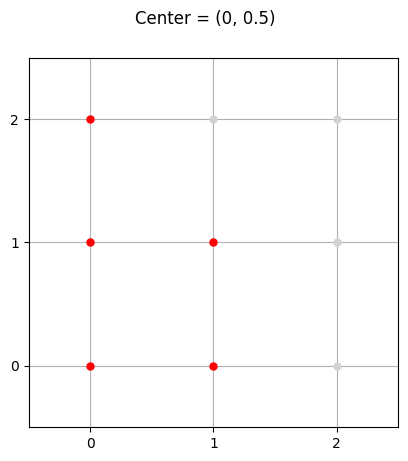

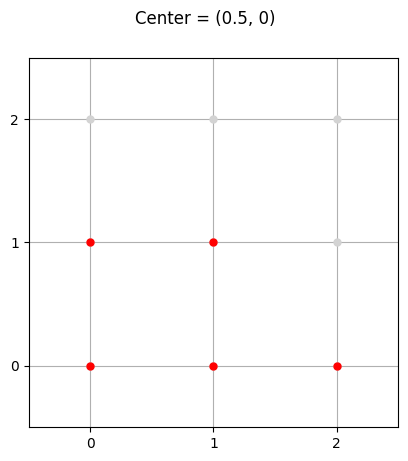

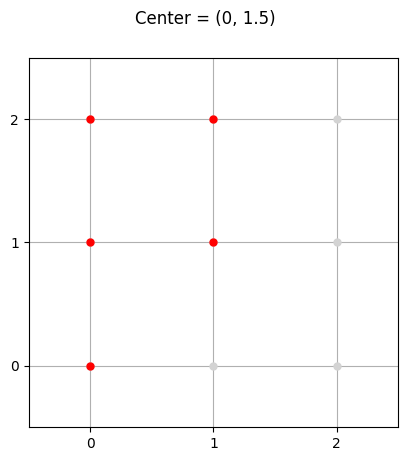

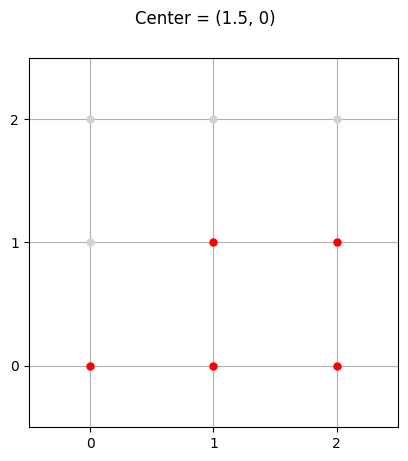

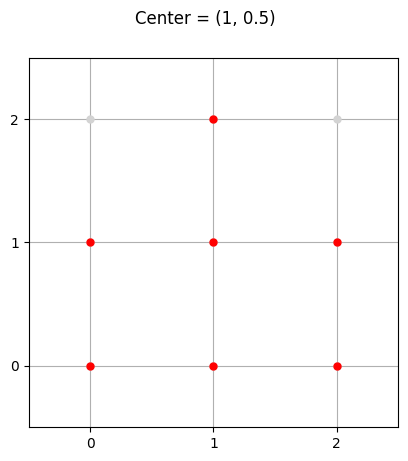

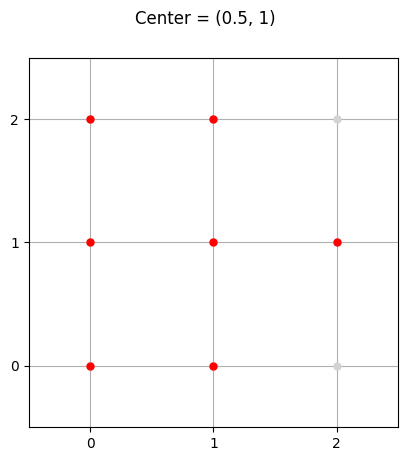

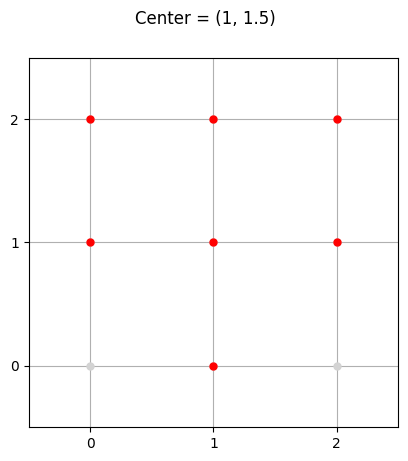

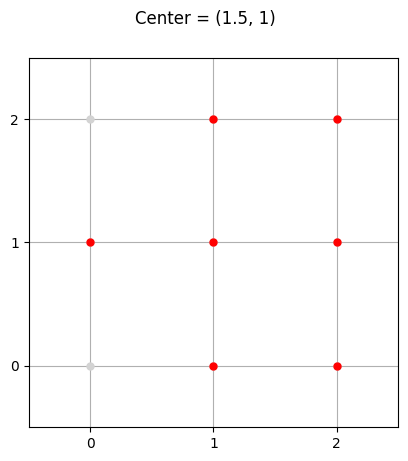

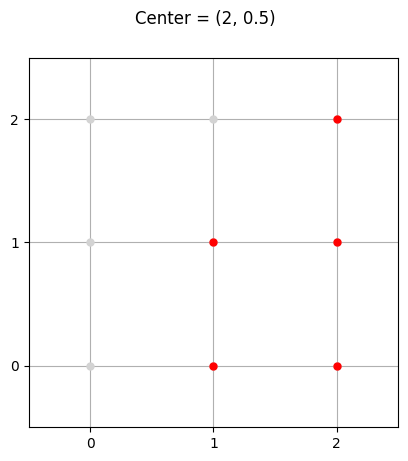

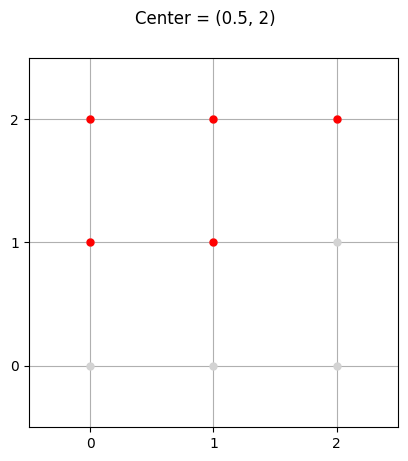

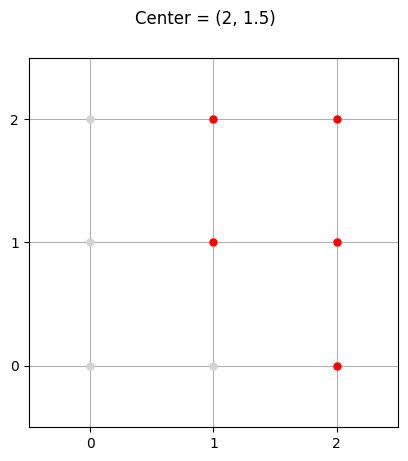

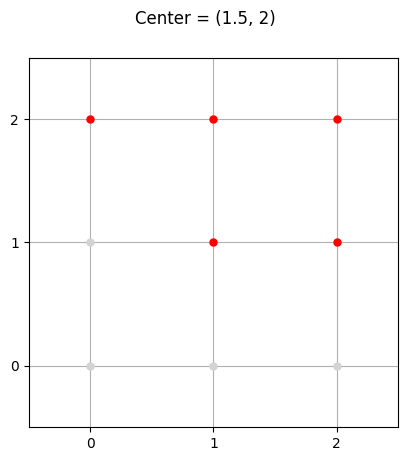

In [58]:
from qnute.helpers.lattice import get_m_sphere

d = 2
l = 3
D = 4

for i in range(l):
    for j in range(l-1):
        center = (i,j + 0.5)
        plot_lattice(l, get_m_sphere(center, D//2, d, l), f'Center = {center}')
        center = (j + 0.5,i)
        plot_lattice(l, get_m_sphere(center, D//2, d, l), f'Center = {center}')

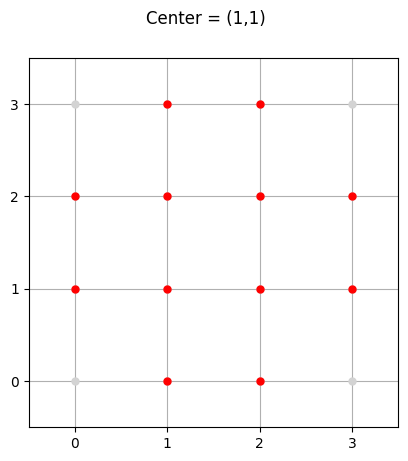

In [68]:
plot_lattice(4, get_m_sphere((1.5,1.5), 2, d, 4), f'Center = (1,1)')